In [1]:
run_gridsearch = False
skip_best_model_validation = True
skip_best_model_test = True
verbose = False
GPU_SETTING = -1
NUM_ENSEMBLES = 5
BASIN = "guerneville"
MODE = "daily"
RUN_LABEL = "BASELINE"
READ_STAMP = "20250815T000000Z"

In [2]:
hyperparam_space = {
    "hidden_size": [64, 128, 256],
    "output_dropout": [0.4],
    "seq_length": [90, 120],
    "num_layers": [1],
    "epochs": [16, 32, 48],
    "batch_size": [64, 128, 256],
    "schedule_pairs": [
        ((0.5, 0.25), (0.01, 0.005, 0.001))
    ]
}

In [3]:
import sys
import pandas as pd
import os
import itertools
from pathlib import Path
from tqdm import tqdm
import warnings
from datetime import datetime
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
current_dir = os.getcwd()
print(current_dir)

/Users/canruso/Desktop/UCB-USACE-LSTMs/notebooks/basins/guerneville


In [5]:
library_path = os.path.join('..', '..', '..','..','UCB-USACE-RR-PROJECT')
sys.path.insert(0, library_path)
print(sys.path)

['../../../../UCB-USACE-LSTMs', '/Users/canruso/Desktop/UCB-USACE-LSTMs/notebooks/basins/guerneville', '/Users/canruso/Desktop', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python310.zip', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/lib-dynload', '', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/setuptools/_vendor']


In [6]:
from neuralhydrology.evaluation.metrics import *
from UCB_training.UCB_train import UCB_trainer
from UCB_training.UCB_utils import (fractional_multi_lr, write_paths, to_path_or_list, ensure_output_tree, set_active_context, data_dir, repo_root, get_output_dir, make_run_stamp, get_yaml_path, ctx_for, hparams_exists, save_hparams, load_hparams, runs_latest_path, archive_runs_json, read_csv_artifact, ensure_shared_tree)
from UCB_training.UCB_plotting import (plot_timeseries_comparison, scatter_triptych_pngs_v3, ts_triptych_v3)

In [7]:
current_path = os.getcwd()
library_path = current_path.split('UCB-USACE-RR-PROJECT')[0] + 'UCB-USACE-RR-PROJECT'

In [8]:
RUNS_FILE = str(runs_latest_path(BASIN, MODE, RUN_LABEL))
SHOULD_STAMP = not (skip_best_model_validation and skip_best_model_test)
RUN_STAMP = make_run_stamp() if SHOULD_STAMP else None
ACTIVE_STAMP = RUN_STAMP if RUN_STAMP is not None else READ_STAMP

In [9]:
set_active_context(basin=BASIN, resolution=MODE, run_stamp=ACTIVE_STAMP, run_tag=RUN_LABEL, append_stamp_to_filenames=False)
SHARED_FOLDER = ensure_shared_tree(BASIN, MODE)
RUNS_PARENT = SHARED_FOLDER / "runs" / (f"{RUN_LABEL}_{RUN_STAMP}" if RUN_STAMP else RUN_LABEL)

print("NH runs will be written under:")
print(RUNS_PARENT.resolve())

NH runs will be written under:
/Users/canruso/Desktop/UCB-USACE-LSTMs/outputs/guerneville/daily_shared/runs/BASELINE


In [10]:
path_to_csv = data_dir()
path_to_yaml = get_yaml_path("guerneville_gage_nlayer")
path_to_physics_data = path_to_csv / "Guerneville_daily_shift.csv"

In [11]:
features_with_physics = [
    "BIG SULPHUR CR ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "DRY CREEK 10 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "EF RUSSIAN 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "GREEN VALLEY ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "LAGUNA ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 30 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 40 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 50 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 60 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 70 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "SANTA ROSA CR 10 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "SANTA ROSA CR 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "WF RUSSIAN ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "BIG SULPHUR CR PRECIP-INC SCREENED",
    "DRY CREEK 10 PRECIP-INC SCREENED",
    "EF RUSSIAN 20 PRECIP-INC SCREENED",
    "GREEN VALLEY PRECIP-INC SCREENED",
    "LAGUNA PRECIP-INC SCREENED",
    "RUSSIAN 20 PRECIP-INC SCREENED",
    "RUSSIAN 30 PRECIP-INC SCREENED",
    "RUSSIAN 40 PRECIP-INC SCREENED",
    "RUSSIAN 50 PRECIP-INC SCREENED",
    "RUSSIAN 60 PRECIP-INC SCREENED",
    "RUSSIAN 70 PRECIP-INC SCREENED",
    "SANTA ROSA CR 10 PRECIP-INC SCREENED",
    "SANTA ROSA CR 20 PRECIP-INC SCREENED",
    "WF RUSSIAN PRECIP-INC SCREENED",
    "UKIAH CA HUMIDITY USAF-NOAA",
    "UKIAH CA SOLAR RADIATION USAF-NOAA",
    "UKIAH CA TEMPERATURE USAF-NOAA",
    "UKIAH CA WINDSPEED USAF-NOAA",
    "SANTA ROSA CA HUMIDITY USAF-NOAA",
    "SANTA ROSA CA SOLAR RADIATION USAF-NOAA",
    "SANTA ROSA CA TEMPERATURE USAF-NOAA",
    "SANTA ROSA CA WINDSPEED USAF-NOAA",
    "UKIAH CA FLOW USGS-MERGED",
    "GEYSERVILLE CA FLOW USGS-MERGED",
    "Guerneville Gage FLOW",
    "Big Sulphur Cr ET-POTENTIAL",
    "Big Sulphur Cr FLOW",
    "Big Sulphur Cr FLOW-BASE",
    "Big Sulphur Cr INFILTRATION",
    "Big Sulphur Cr PERC-SOIL",
    "Big Sulphur Cr SATURATION FRACTION",
    "Dry Creek 10 ET-POTENTIAL",
    "Dry Creek 10 FLOW",
    "Dry Creek 10 FLOW-BASE",
    "Dry Creek 10 INFILTRATION",
    "Dry Creek 10 PERC-SOIL",
    "Dry Creek 10 SATURATION FRACTION",
    "Green Valley ET-POTENTIAL",
    "Green Valley FLOW",
    "Green Valley FLOW-BASE",
    "Green Valley INFILTRATION",
    "Green Valley PERC-SOIL",
    "Green Valley SATURATION FRACTION",
    "Laguna ET-POTENTIAL",
    "Laguna FLOW",
    "Laguna FLOW-BASE",
    "Laguna INFILTRATION",
    "Laguna PERC-SOIL",
    "Laguna SATURATION FRACTION",
    "Russian 20 ET-POTENTIAL",
    "Russian 20 FLOW",
    "Russian 20 FLOW-BASE",
    "Russian 20 INFILTRATION",
    "Russian 20 PERC-SOIL",
    "Russian 20 SATURATION FRACTION",
    "Russian 30 ET-POTENTIAL",
    "Russian 30 FLOW",
    "Russian 30 FLOW-BASE",
    "Russian 30 INFILTRATION",
    "Russian 30 PERC-SOIL",
    "Russian 30 SATURATION FRACTION",
    "Russian 40 ET-POTENTIAL",
    "Russian 40 FLOW",
    "Russian 40 FLOW-BASE",
    "Russian 40 INFILTRATION",
    "Russian 40 PERC-SOIL",
    "Russian 40 SATURATION FRACTION",
    "Russian 50 ET-POTENTIAL",
    "Russian 50 FLOW",
    "Russian 50 FLOW-BASE",
    "Russian 50 INFILTRATION",
    "Russian 50 PERC-SOIL",
    "Russian 50 SATURATION FRACTION",
    "Russian 60 ET-POTENTIAL",
    "Russian 60 FLOW",
    "Russian 60 FLOW-BASE",
    "Russian 60 INFILTRATION",
    "Russian 60 PERC-SOIL",
    "Russian 60 SATURATION FRACTION",
    "Russian 70 ET-POTENTIAL",
    "Russian 70 FLOW",
    "Russian 70 FLOW-BASE",
    "Russian 70 INFILTRATION",
    "Russian 70 PERC-SOIL",
    "Russian 70 SATURATION FRACTION",
    "Santa Rosa Cr 10 ET-POTENTIAL",
    "Santa Rosa Cr 10 FLOW",
    "Santa Rosa Cr 10 FLOW-BASE",
    "Santa Rosa Cr 10 INFILTRATION",
    "Santa Rosa Cr 10 PERC-SOIL",
    "Santa Rosa Cr 10 SATURATION FRACTION",
    "Santa Rosa Cr 20 ET-POTENTIAL",
    "Santa Rosa Cr 20 FLOW",
    "Santa Rosa Cr 20 FLOW-BASE",
    "Santa Rosa Cr 20 INFILTRATION",
    "Santa Rosa Cr 20 PERC-SOIL",
    "Santa Rosa Cr 20 SATURATION FRACTION",
    "WF Russian ET-POTENTIAL",
    "WF Russian FLOW",
    "WF Russian FLOW-BASE",
    "WF Russian INFILTRATION",
    "WF Russian PERC-SOIL",
    "WF Russian SATURATION FRACTION"
]

In [12]:
no_physics_results = []
physics_results = []

In [13]:
start_time = datetime.utcnow()
print("Start time:", start_time.strftime("%Y-%m-%d %H:%M:%S"))

Start time: 2025-08-20 18:11:59


In [14]:
hyperparam_names = []
for i, hp in enumerate(hyperparam_space.keys()):
    hyperparam_names.append(hp)

total_iters = 1
for name in hyperparam_names:
    total_iters *= len(hyperparam_space[name])

if run_gridsearch or not hparams_exists(BASIN, MODE, RUN_LABEL):
    for combinations in tqdm(
        itertools.product(*[hyperparam_space[hp] for hp in hyperparam_names]), 
        desc="Grid-Search", 
        total=total_iters, 
        unit="it", 
        ncols=60, 
        ascii=True):

        hp_run = {}
        j = 0
        schedule_pairs = None
        
        while j < len(hyperparam_names):
            name = hyperparam_names[j]
            val = combinations[j]

            if name == "seq_length":
                hp_run["seq_length"] = val

            elif name == "schedule_pairs":
                schedule_pairs = val
            else:
                hp_run[name] = val

            j += 1

        if schedule_pairs is not None:
            fractions, rates = schedule_pairs
            hp_run["learning_rate"] = fractional_multi_lr(
                epochs=int(hp_run["epochs"]), fractions=list(fractions), lrs=list(rates))
        else:
            hp_run.setdefault("learning_rate", {0: 0.01, 30: 0.005, 40: 0.001})
    
        if verbose:
            print(f"\nNoPhysics: {hp_run}")
            
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp_run,
            input_features=None,
            physics_informed=False,
            physics_data_file=None,
            hourly=False,  
            extend_train_period=False,
            gpu=GPU_SETTING,
            verbose=verbose,
            runs_parent=RUNS_PARENT,
            run_label=RUN_LABEL,
            run_stamp=RUN_STAMP)
        
        trainer.train()
        csv_path, metrics_dict = trainer.results()
        
        row_data = {}
        j = 0
        while j < len(hyperparam_names):
            row_data[hyperparam_names[j]] = combinations[j]
            j += 1

        row_data["learning_rate"] = str(hp_run["learning_rate"])
            
        for k, v in metrics_dict.items():
            row_data[k] = v
        
        no_physics_results.append(row_data)

    df_no_physics = pd.DataFrame(no_physics_results)
    df_no_physics.sort_values(by="NSE", ascending=False, inplace=True)
    df_no_physics.reset_index(drop=True, inplace=True)
else:
    print("Skipping grid search!")

Skipping grid search!


In [15]:
if run_gridsearch or not hparams_exists(BASIN, MODE, RUN_LABEL):   
    for combinations in tqdm(
        itertools.product(*[hyperparam_space[hp] for hp in hyperparam_names]), 
        desc="Grid-Search", 
        total=total_iters, 
        unit="it", 
        ncols=60, 
        ascii=True):
            
        hp_run = {}
        j = 0
        schedule_pairs = None
        
        while j < len(hyperparam_names):
            name = hyperparam_names[j]
            val  = combinations[j]

            if name == "seq_length":
                hp_run["seq_length"] = val

            elif name == "schedule_pairs":
                schedule_pairs = val

            else:
                hp_run[name] = val

            j += 1

        if schedule_pairs is not None:
            fractions, rates = schedule_pairs
            hp_run["learning_rate"] = fractional_multi_lr(
                epochs=int(hp_run["epochs"]), fractions=list(fractions), lrs=list(rates))
        else:
            hp_run.setdefault("learning_rate", {0: 0.01, 30: 0.005, 40: 0.001})
            
        if verbose:
            print(f"\nPhysics: {hp_run}")
            
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp_run,
            input_features=features_with_physics,
            physics_informed=True,
            physics_data_file=path_to_physics_data,
            hourly=False,
            extend_train_period=False,
            gpu=GPU_SETTING,
            verbose=verbose,
            runs_parent=RUNS_PARENT,
            run_label=RUN_LABEL,
            run_stamp=RUN_STAMP)
        
        trainer.train()
        csv_path, metrics_dict = trainer.results()

        row_data = {}
        j = 0
        while j < len(hyperparam_names):
            row_data[hyperparam_names[j]] = combinations[j]
            j += 1

        row_data["learning_rate"] = str(hp_run["learning_rate"])

        for k, v in metrics_dict.items():
            row_data[k] = v
            
        physics_results.append(row_data)
    df_physics = pd.DataFrame(physics_results)
    df_physics.sort_values(by="NSE", ascending=False, inplace=True)
    df_physics.reset_index(drop=True, inplace=True)
    best_no_phys = df_no_physics.iloc[0].to_dict()
    best_phys = df_physics.iloc[0].to_dict()
    best_no_phys["model_type"] = "no_physics"
    best_phys["model_type"] = "physics"
    best_params_df = pd.DataFrame([best_no_phys, best_phys])
    save_hparams(best_df=best_params_df, basin=BASIN, mode=MODE, label=RUN_LABEL, run_stamp=RUN_STAMP, df_no=df_no_physics, df_phys=df_physics)
else:
    print("Skipping grid search!")

Skipping grid search!


In [16]:
try:
    if run_gridsearch:
        print("\n[INFO] Using best_params_df from the just-completed grid search (ignoring READ_STAMP).")
    else:
        print("\nLoading best hyperparams from CSV...")
        best_params_df = load_hparams(BASIN, MODE, RUN_LABEL, stamp=READ_STAMP)
except FileNotFoundError as e:
    raise SystemExit(f"[ERROR] {e}  (Set run_gridsearch=True to generate it.)")

best_no_phys = best_params_df.query("model_type == 'no_physics'").iloc[0].to_dict()
best_phys = best_params_df.query("model_type == 'physics'").iloc[0].to_dict()

best_no_physics_params = {}
j = 0
while j < len(hyperparam_names):
    name = hyperparam_names[j]
    if name == "output_dropout":
        best_no_physics_params[name] = float(best_no_phys[name])
        j += 1

    elif name == "seq_length":
        best_no_physics_params["seq_length"] = int(best_no_phys["seq_length"])
        j += 1

    elif name == "schedule_pairs":
        j += 1

    else:
        best_no_physics_params[name] = int(best_no_phys[name])
        j += 1

if "learning_rate" in best_no_phys and pd.notna(best_no_phys["learning_rate"]):
    best_no_physics_params["learning_rate"] = eval(str(best_no_phys["learning_rate"]))

elif "schedule_pairs" in best_no_phys and pd.notna(best_no_phys["schedule_pairs"]):
    sp = best_no_phys["schedule_pairs"]
    if isinstance(sp, str):
        sp = eval(sp)
    fractions, rates = sp
    best_no_physics_params["learning_rate"] = fractional_multi_lr(
        epochs=int(best_no_physics_params["epochs"]),
        fractions=list(fractions),
        lrs=list(rates))

else:
    best_no_physics_params["learning_rate"] = {0: 0.01, 30: 0.005, 40: 0.001}

best_physics_params = {}
j = 0
while j < len(hyperparam_names):
    name = hyperparam_names[j]
    if name == "output_dropout":
        best_physics_params[name] = float(best_phys[name])
        j += 1

    elif name == "seq_length":
        best_physics_params["seq_length"] = int(best_phys["seq_length"])
        j += 1

    elif name == "schedule_pairs":
        j += 1

    else:
        best_physics_params[name] = int(best_phys[name])
        j += 1

if "learning_rate" in best_phys and pd.notna(best_phys["learning_rate"]):
    best_physics_params["learning_rate"] = eval(str(best_phys["learning_rate"]))

elif "schedule_pairs" in best_phys and pd.notna(best_phys["schedule_pairs"]):
    sp = best_phys["schedule_pairs"]
    if isinstance(sp, str):
        sp = eval(sp)
    fractions, rates = sp
    best_physics_params["learning_rate"] = fractional_multi_lr(
        epochs=int(best_physics_params["epochs"]),
        fractions=list(fractions),
        lrs=list(rates))

else:
    best_physics_params["learning_rate"] = {0: 0.01, 30: 0.005, 40: 0.001}

print("Loaded best hyperparams from CSV:")
print("Best NO-PHYS:", best_no_physics_params)
print("Best PHYS:", best_physics_params)

Loaded best hyperparams from CSV:
Best NO-PHYS: {'hidden_size': 256, 'seq_length': 90, 'num_layers': 1, 'epochs': 48, 'batch_size': 64}
Best PHYS: {'hidden_size': 64, 'seq_length': 90, 'num_layers': 1, 'epochs': 48, 'batch_size': 64}


### Re-run validation with best hyperparameters

In [17]:
if not skip_best_model_validation:
    lstmNoPhysicsValBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=False,
        extend_train_period=False,
        gpu=GPU_SETTING,
        # num_ensemble_members = NUM_ENSEMBLES,
        verbose = verbose,
        runs_parent=RUNS_PARENT,
        run_label=RUN_LABEL,
        run_stamp=RUN_STAMP)
    
    lstmNoPhysicsValBest.train()
    no_physics_val_csv, no_physics_val_metrics = lstmNoPhysicsValBest.results()
    no_physics_val_metrics

In [18]:
if not skip_best_model_validation:
    lstmPhysicsValBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data,
        hourly=False,
        extend_train_period=False,
        gpu=GPU_SETTING,
        # num_ensemble_members = NUM_ENSEMBLES,
        verbose = verbose,
        runs_parent=RUNS_PARENT,
        run_label=RUN_LABEL,
        run_stamp=RUN_STAMP)
    
    lstmPhysicsValBest.train()
    physics_val_csv, physics_val_metrics = lstmPhysicsValBest.results()
    physics_val_metrics

HMS
  NSE = 0.882
  PBIAS = -5.314
LSTM
  NSE = 0.802
  PBIAS = 5.184
PILSTM
  NSE = 0.864
  PBIAS = -5.502


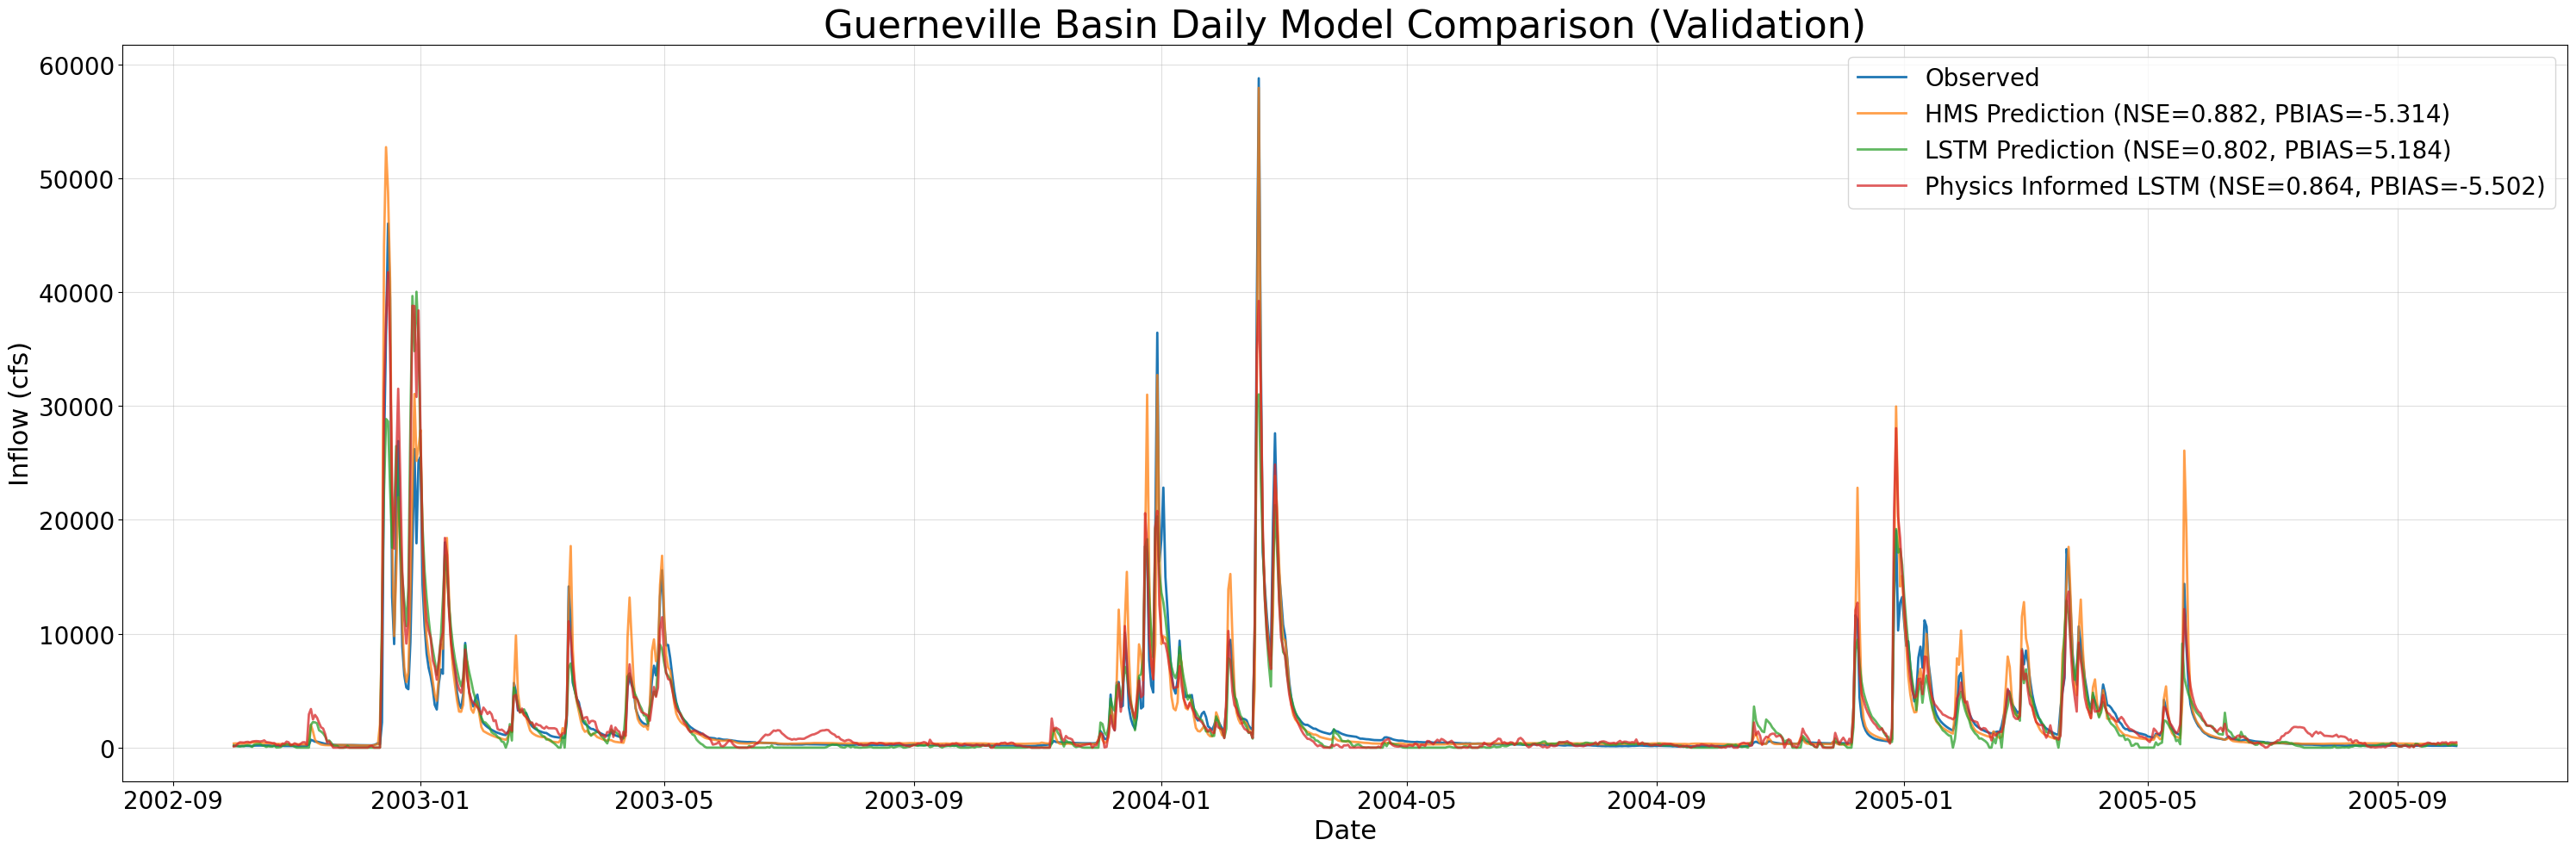

In [19]:
if not skip_best_model_validation:
    plot_timeseries_comparison(source=(no_physics_val_csv, physics_val_csv, path_to_physics_data), title="Guerneville Basin Daily Model Comparison (Validation)", backend="mpl", metrics=["NSE", "PBIAS"], metrics_out="guerneville_daily_val_metrics.csv", ts_out="guerneville_daily_val_combined_ts.csv", fig_out="guerneville_daily_val_model_comparison.png", legend_font=20, axis_font=22)
else:
    combined_df_val = read_csv_artifact("guerneville_daily_val_combined_ts.csv", kind="csv", period="validation", stamp = READ_STAMP, run_label = RUN_LABEL)           
    plot_timeseries_comparison(source=combined_df_val, title="Guerneville Basin Daily Model Comparison (Validation)", backend="mpl", metrics=["NSE", "PBIAS"], metrics_out="guerneville_daily_val_metrics.csv", ts_out="guerneville_daily_val_combined_ts.csv", fig_out="guerneville_daily_val_model_comparison.png", legend_font=20, axis_font=22)

In [20]:
if skip_best_model_validation:
    val_metrics = read_csv_artifact("guerneville_daily_val_metrics.csv", kind="metrics", period="validation", index_col=0, stamp = READ_STAMP, run_label = RUN_LABEL)
    print(val_metrics)

                      HMS          LSTM        PILSTM
NSE          8.819596e-01  8.020969e-01  8.639267e-01
MSE          2.922175e+06  4.899232e+06  3.368591e+06
RMSE         1.709437e+03  2.213421e+03  1.835372e+03
KGE          8.769172e-01  8.742947e-01  9.117650e-01
Alpha-NSE    1.099694e+00  9.490641e-01  1.019307e+00
Beta-KGE     1.053142e+00  9.481572e-01  1.055024e+00
Beta-NSE     2.564937e-02 -2.502220e-02  2.655780e-02
Pearson-r    9.511483e-01  8.974345e-01  9.337809e-01
FHV          1.141926e+01 -6.370275e+00  7.682018e+00
FMS         -1.806008e+01  3.571524e+01 -1.038902e+01
FLV          7.349668e+00 -7.716088e+02 -2.383823e+03
Peak-Timing  2.000000e-01  6.000000e-01  0.000000e+00
Peak-MAPE    3.080989e+01  3.753715e+01  2.631399e+01
PBIAS       -5.314225e+00  5.184283e+00 -5.502440e+00


### Re-run testing with best hyperparameters

In [21]:
if not skip_best_model_test:
    lstmNoPhysicsExtBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=False,
        extend_train_period=True,  
        gpu=GPU_SETTING,
        num_ensemble_members = NUM_ENSEMBLES,
        verbose = verbose,
        runs_parent=RUNS_PARENT,
        run_label=RUN_LABEL,
        run_stamp=RUN_STAMP)
    
    lstmNoPhysicsExtBest.train()
    no_physics_test_csv, no_physics_test_metrics = lstmNoPhysicsExtBest.results('test')
    no_physics_test_metrics

In [22]:
if not skip_best_model_test:
    lstmPhysicsExtBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data,
        hourly=False,
        extend_train_period=True,
        gpu=GPU_SETTING,
        num_ensemble_members = NUM_ENSEMBLES,
        verbose = verbose,
        runs_parent=RUNS_PARENT,
        run_label=RUN_LABEL,
        run_stamp=RUN_STAMP)
    
    lstmPhysicsExtBest.train()
    physics_test_csv, physics_test_metrics = lstmPhysicsExtBest.results('test')
    physics_test_metrics

HMS
  NSE = 0.850
  PBIAS = -13.709
LSTM
  NSE = 0.860
  PBIAS = -12.945
PILSTM
  NSE = 0.864
  PBIAS = -13.623


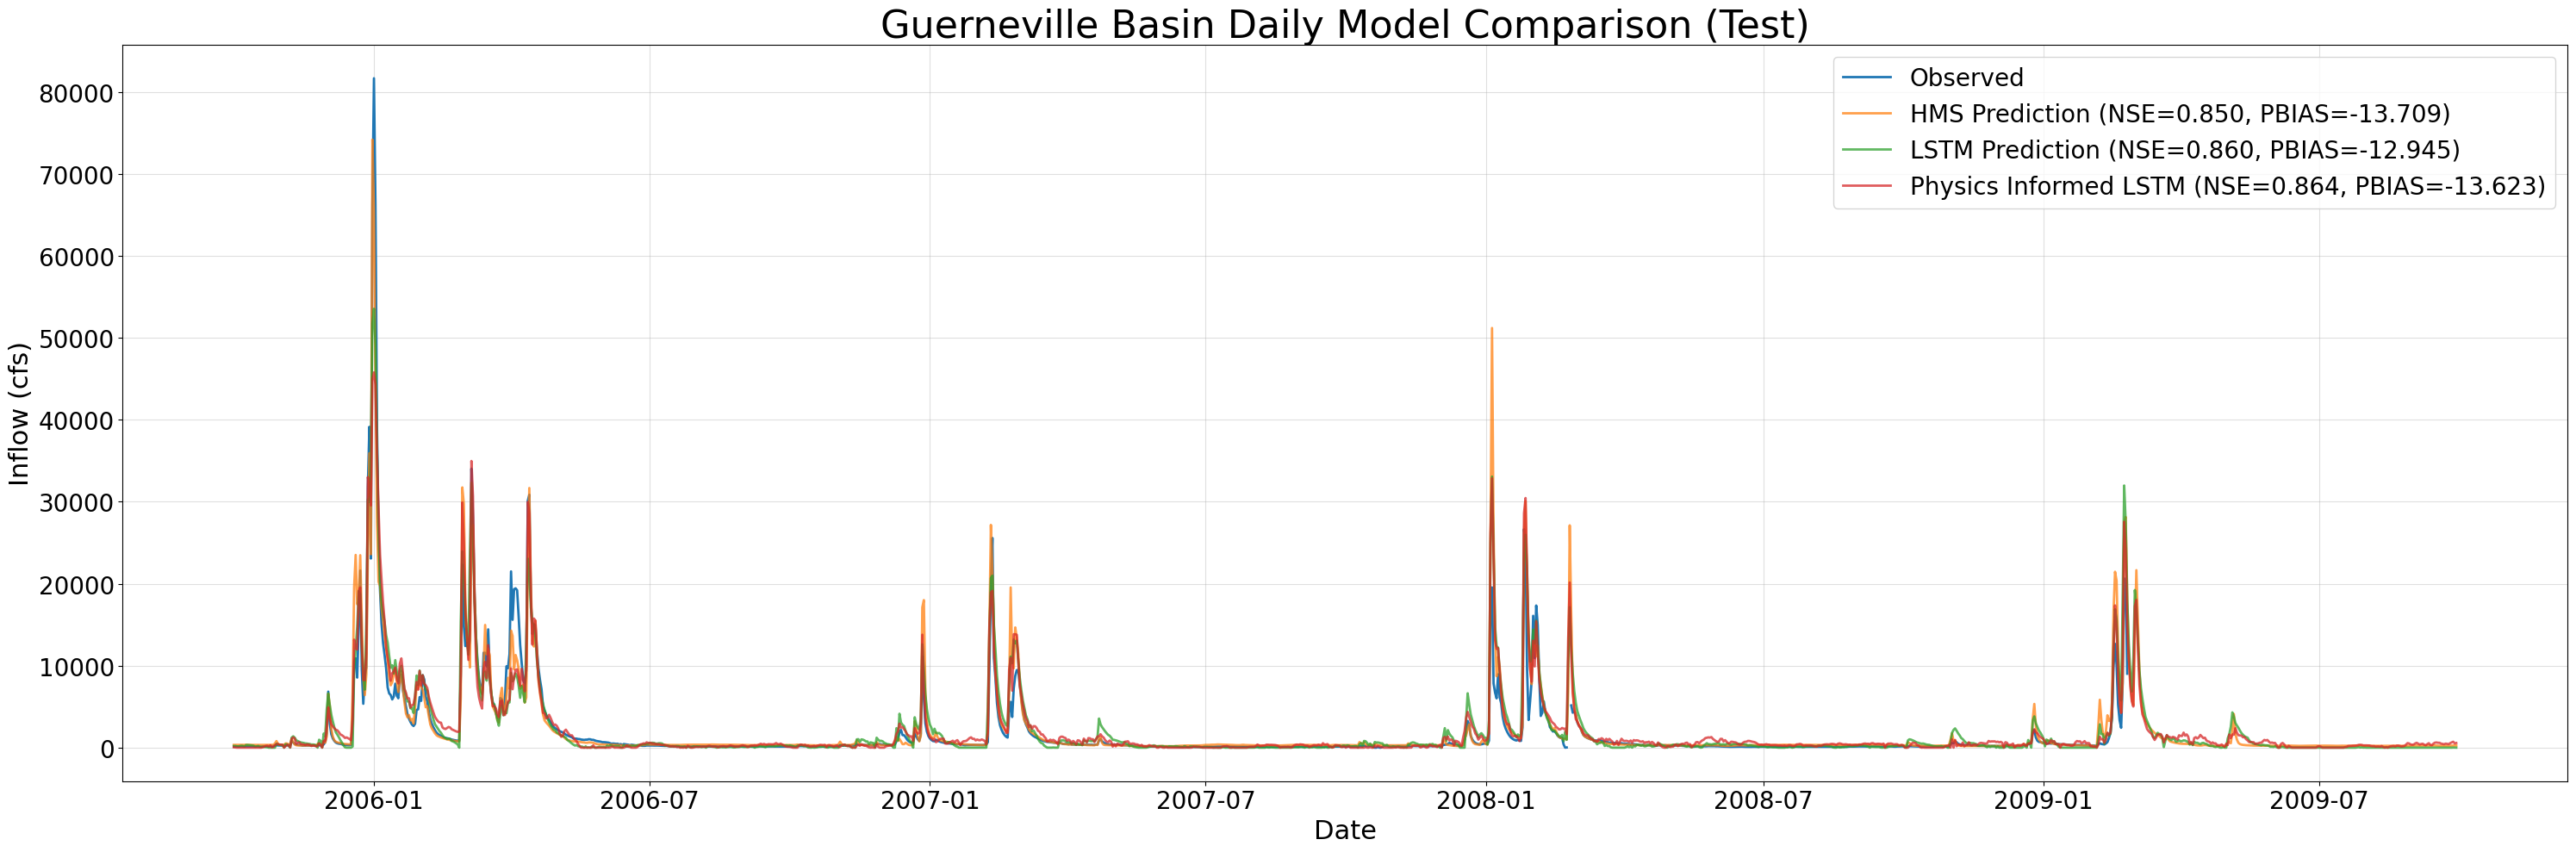

In [23]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Guerneville Basin Daily Model Comparison (Test)", backend="mpl", metrics=["NSE", "PBIAS"], metrics_out="guerneville_daily_test_metrics.csv", ts_out="guerneville_daily_test_combined_ts.csv", fig_out="guerneville_daily_test_model_comparison.png", legend_font=20, axis_font=22)
else:
    combined_df = read_csv_artifact("guerneville_daily_test_combined_ts.csv", kind="csv", period="test", stamp = READ_STAMP, run_label = RUN_LABEL)
    plot_timeseries_comparison(source=combined_df, title="Guerneville Basin Daily Model Comparison (Test)", backend="mpl", metrics=["NSE", "PBIAS"], metrics_out="guerneville_daily_test_metrics.csv", ts_out="guerneville_daily_test_combined_ts.csv", fig_out="guerneville_daily_test_model_comparison.png", legend_font=20, axis_font=22)

In [24]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Guerneville Basin Daily Model Comparison", backend="plotly", metrics=["NSE", "PBIAS"], metrics_out="guerneville_daily_test_metrics.csv", ts_out="guerneville_daily_test_combined_ts.csv", legend_font=12, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Guerneville Basin Daily Model Comparison", backend="plotly", metrics=["NSE", "PBIAS"], metrics_out="guerneville_daily_test_metrics.csv", ts_out="guerneville_daily_test_combined_ts.csv", legend_font=12, axis_font=22)

HMS
  NSE = 0.850
  PBIAS = -13.709
LSTM
  NSE = 0.860
  PBIAS = -12.945
PILSTM
  NSE = 0.864
  PBIAS = -13.623


In [25]:
test_metrics = read_csv_artifact("guerneville_daily_test_metrics.csv", kind="metrics", period="test", index_col=0, stamp = READ_STAMP, run_label = RUN_LABEL)
print(test_metrics)

                      HMS          LSTM        PILSTM
NSE          8.499148e-01  8.604288e-01  8.642596e-01
MSE          4.623214e+06  4.299341e+06  4.181336e+06
RMSE         2.150166e+03  2.073485e+03  2.044831e+03
KGE          8.430313e-01  8.449975e-01  8.307035e-01
Alpha-NSE    1.026757e+00  9.527984e-01  9.270246e-01
Beta-KGE     1.137092e+00  1.129450e+00  1.136232e+00
Beta-NSE     4.800381e-02  4.532793e-02  4.770263e-02
Pearson-r    9.283838e-01  9.290046e-01  9.308867e-01
FHV          2.575220e+00 -4.776223e+00 -3.087031e+00
FMS         -2.409063e+01  4.511755e+01  9.982508e+00
FLV          9.758516e+01  5.202320e+01  4.294186e+01
Peak-Timing  7.500000e-01  5.000000e-01  5.000000e-01
Peak-MAPE    1.465164e+01  3.008668e+01  2.342095e+01
PBIAS       -1.370924e+01 -1.294505e+01 -1.362323e+01


In [26]:
if not skip_best_model_test:
    write_paths("no_physics", lstmNoPhysicsExtBest, filename = RUNS_FILE)
    write_paths("physics", lstmPhysicsExtBest, filename = RUNS_FILE)
    archived_path = archive_runs_json(Path(RUNS_FILE), BASIN, MODE, RUN_LABEL, RUN_STAMP)

In [27]:
end_time = datetime.utcnow()
print("\nEnd time:", end_time.strftime("%Y-%m-%d %H:%M:%S"))
print("Total time:", end_time - start_time)


End time: 2025-08-20 18:12:08
Total time: 0:00:09.203415


##### Additional Plots

In [28]:
if skip_best_model_validation:
    combined_df_val = read_csv_artifact("guerneville_daily_val_combined_ts.csv", kind="csv", period="validation", stamp = READ_STAMP, run_label = RUN_LABEL)
if skip_best_model_test:
    combined_df = read_csv_artifact("guerneville_daily_test_combined_ts.csv", kind="csv", period="test", stamp = READ_STAMP, run_label = RUN_LABEL)

In [29]:
metric_list = ["NSE", "PBIAS"]

wettest_start_val = "2003-10-01"
wettest_end_val = "2004-09-30"
dryest_start_val = "2004-10-01"
dryest_end_val = "2005-09-30"
wettest_start_test = "2005-10-01"
wettest_end_test = "2006-09-30"
dryest_start_test = "2008-10-01"
dryest_end_test = "2009-09-30"

HMS
  NSE = 0.882
  PBIAS = -5.314
LSTM
  NSE = 0.802
  PBIAS = 5.184
PILSTM
  NSE = 0.864
  PBIAS = -5.502


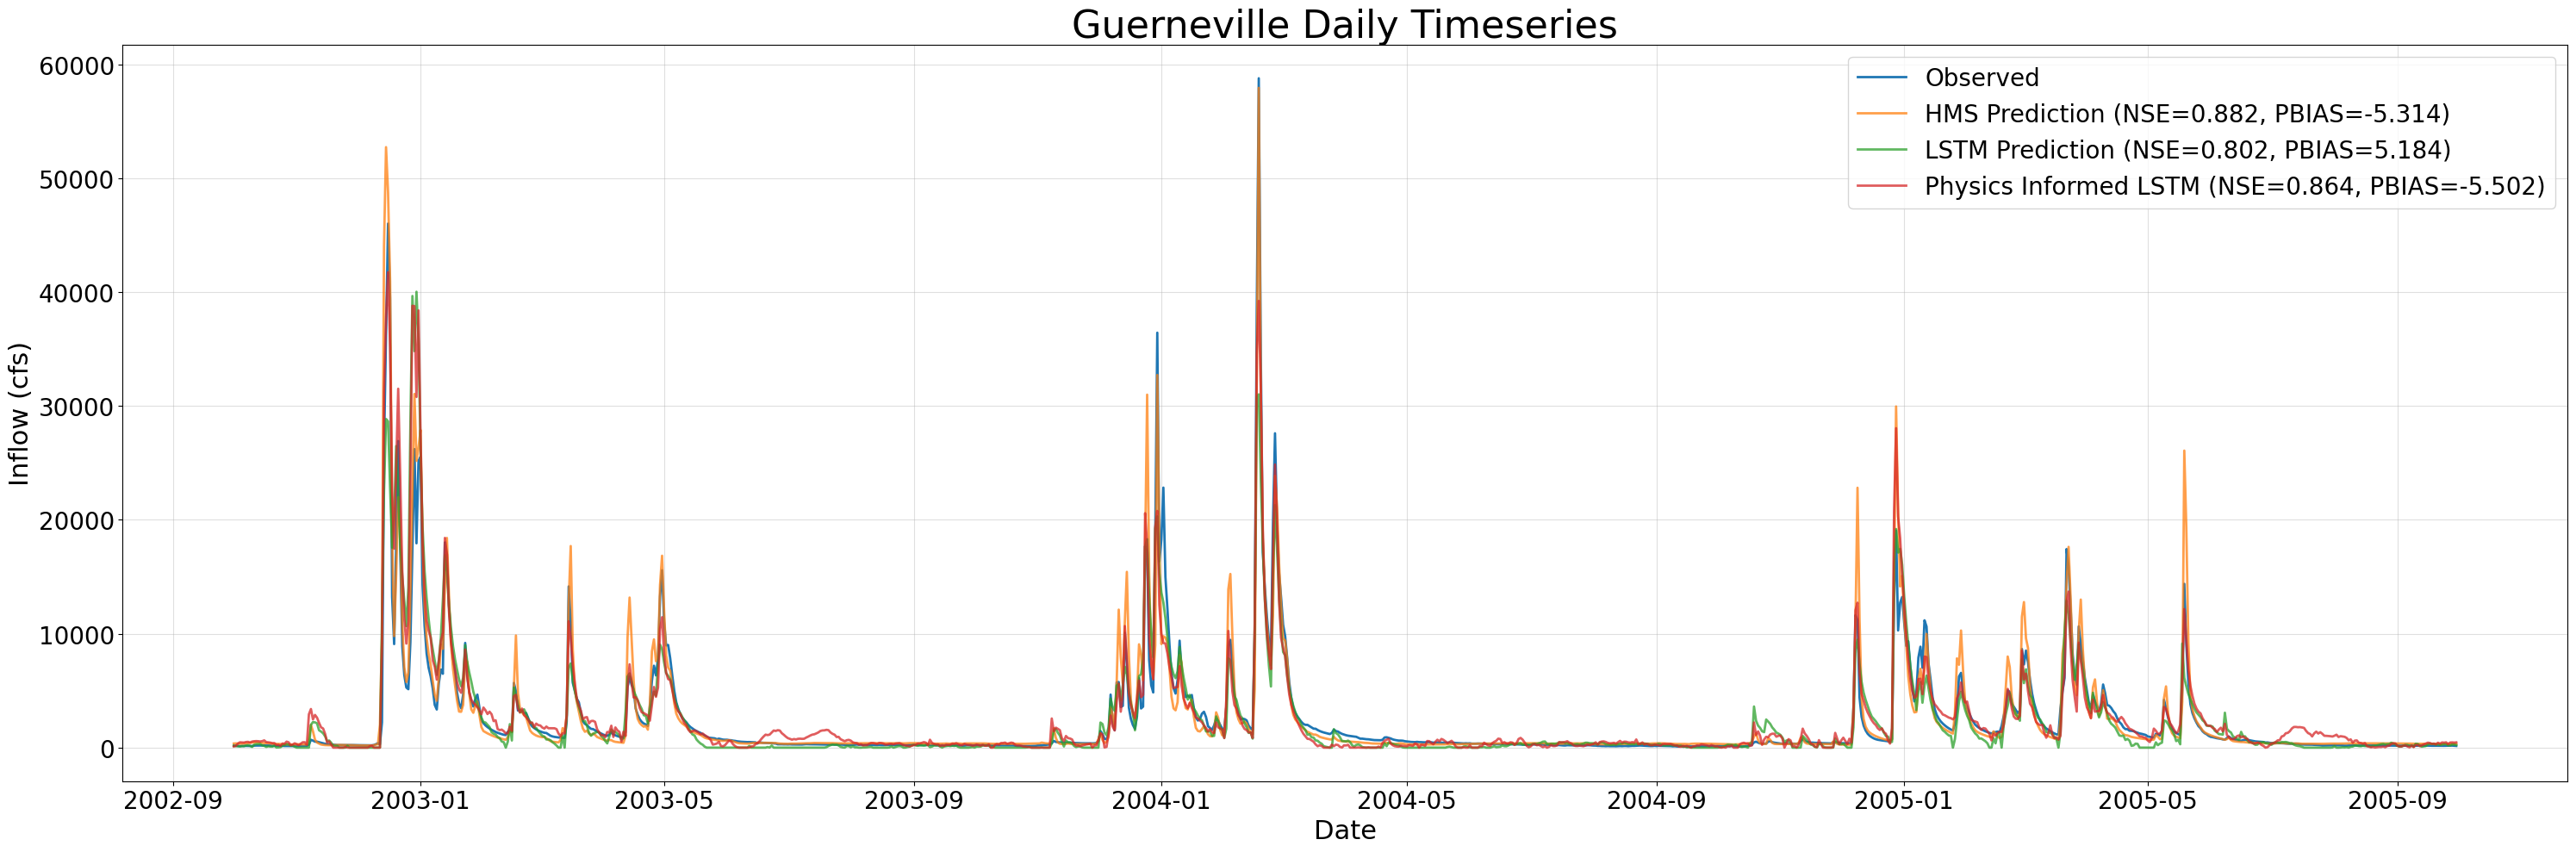

In [30]:
if not skip_best_model_validation: 
    plot_timeseries_comparison(source=(no_physics_val_csv, physics_val_csv, path_to_physics_data), title="Guerneville Daily Timeseries", backend="mpl", metrics=metric_list, metrics_out="guerneville_daily_val_metrics.csv", ts_out="guerneville_daily_val_combined_ts.csv", fig_out="guerneville_daily_val_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df_val, title="Guerneville Daily Timeseries", backend="mpl", metrics=metric_list, metrics_out="guerneville_daily_val_metrics.csv", ts_out="guerneville_daily_val_combined_ts.csv", fig_out="guerneville_daily_val_model_comparison.png", legend_font=20, axis_font=22)

HMS
  NSE = 0.850
  PBIAS = -13.709
LSTM
  NSE = 0.860
  PBIAS = -12.945
PILSTM
  NSE = 0.864
  PBIAS = -13.623


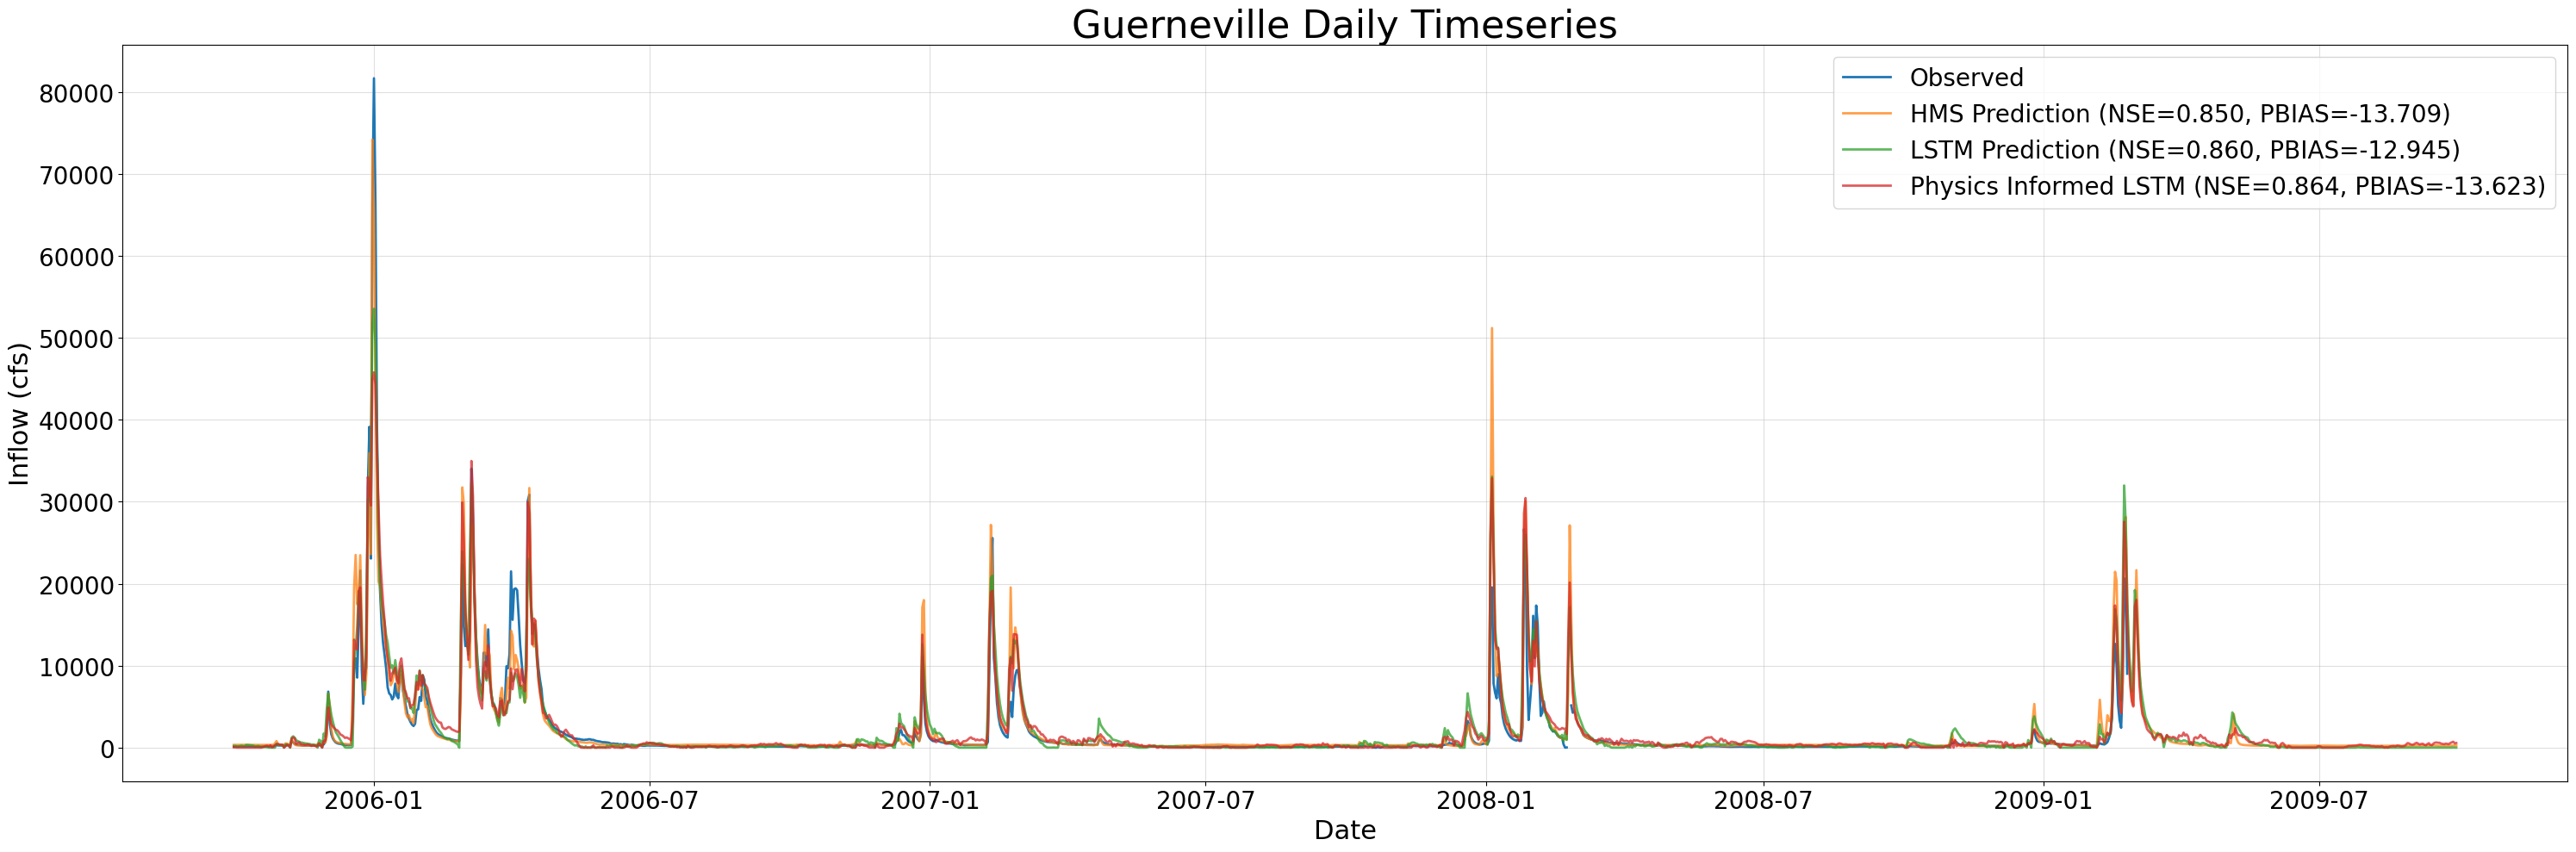

In [31]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Guerneville Daily Timeseries", backend="mpl", metrics=metric_list, metrics_out="guerneville_daily_test_metrics.csv", ts_out="guerneville_daily_test_combined_ts.csv", fig_out="guerneville_daily_test_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Guerneville Daily Timeseries", backend="mpl", metrics=metric_list, metrics_out="guerneville_daily_test_metrics.csv", ts_out="guerneville_daily_test_combined_ts.csv", fig_out="guerneville_daily_test_model_comparison.png", legend_font=20, axis_font=22)

In [32]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Guerneville Daily Timeseries – Interactive", backend="plotly", metrics=metric_list, metrics_out="guerneville_daily_test_metrics.csv", ts_out="guerneville_daily_test_combined_ts.csv", legend_font=12, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Guerneville Daily Timeseries – Interactive", backend="plotly", metrics=metric_list, metrics_out="guerneville_daily_test_metrics.csv", ts_out="guerneville_daily_test_combined_ts.csv", legend_font=12, axis_font=22)

HMS
  NSE = 0.850
  PBIAS = -13.709
LSTM
  NSE = 0.860
  PBIAS = -12.945
PILSTM
  NSE = 0.864
  PBIAS = -13.623


##### Wettest Year Performance

HMS
  NSE = 0.908
  PBIAS = 3.188
LSTM
  NSE = 0.867
  PBIAS = 16.273
PILSTM
  NSE = 0.905
  PBIAS = 15.914


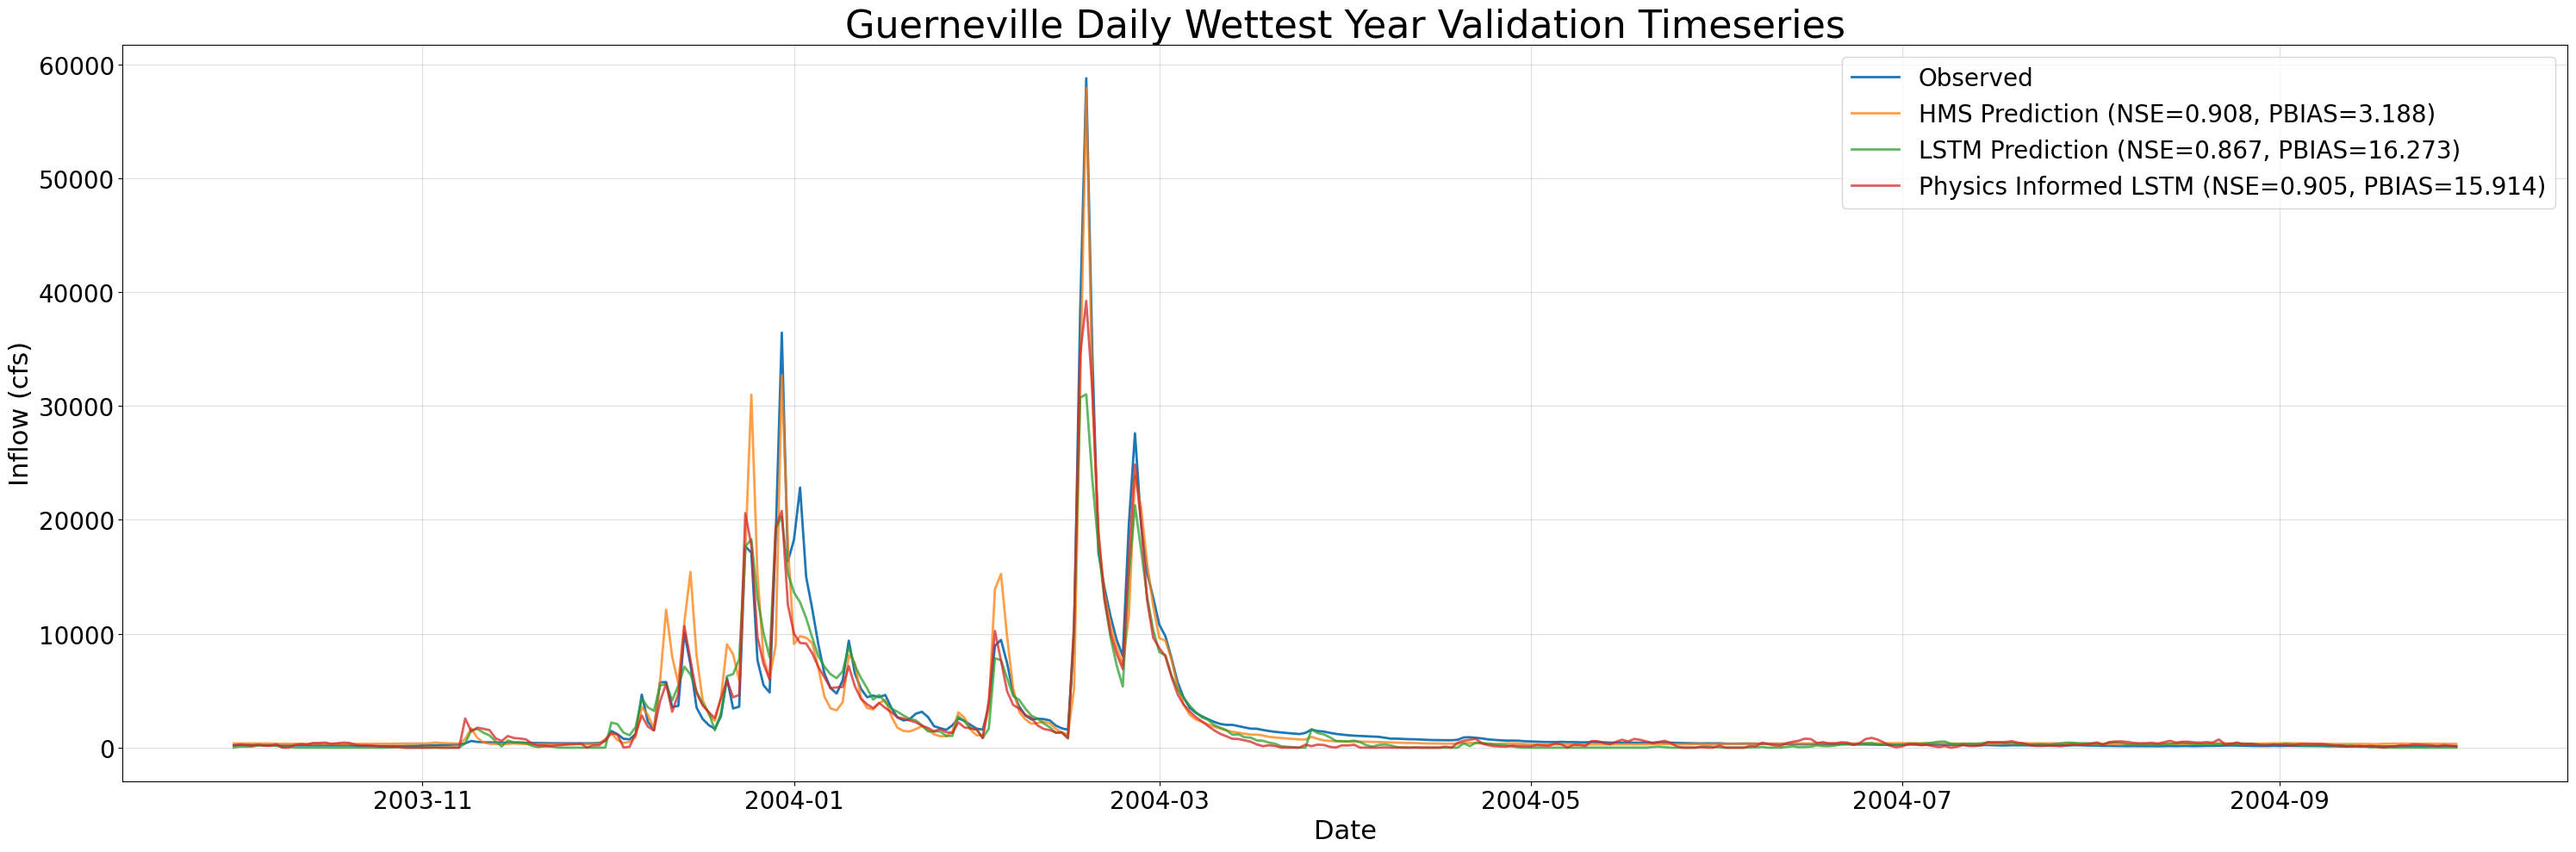

In [33]:
if not skip_best_model_validation:
    plot_timeseries_comparison(source=(no_physics_val_csv, physics_val_csv, path_to_physics_data), title="Guerneville Daily Wettest Year Validation Timeseries", backend="mpl", metrics=metric_list, start_date=wettest_start_val, end_date=wettest_end_val, metrics_out="guerneville_daily_val_wet_metrics.csv", ts_out="guerneville_daily_val_wet_combined_ts.csv", fig_out="guerneville_daily_val_wet_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df_val, title="Guerneville Daily Wettest Year Validation Timeseries", backend="mpl", metrics=metric_list, start_date=wettest_start_val, end_date=wettest_end_val, metrics_out="guerneville_daily_val_wet_metrics.csv", ts_out="guerneville_daily_val_wet_combined_ts.csv", fig_out="guerneville_daily_val_wet_model_comparison.png", legend_font=20, axis_font=22)

HMS
  NSE = 0.913
  PBIAS = 2.807
LSTM
  NSE = 0.890
  PBIAS = 4.817
PILSTM
  NSE = 0.874
  PBIAS = 2.254


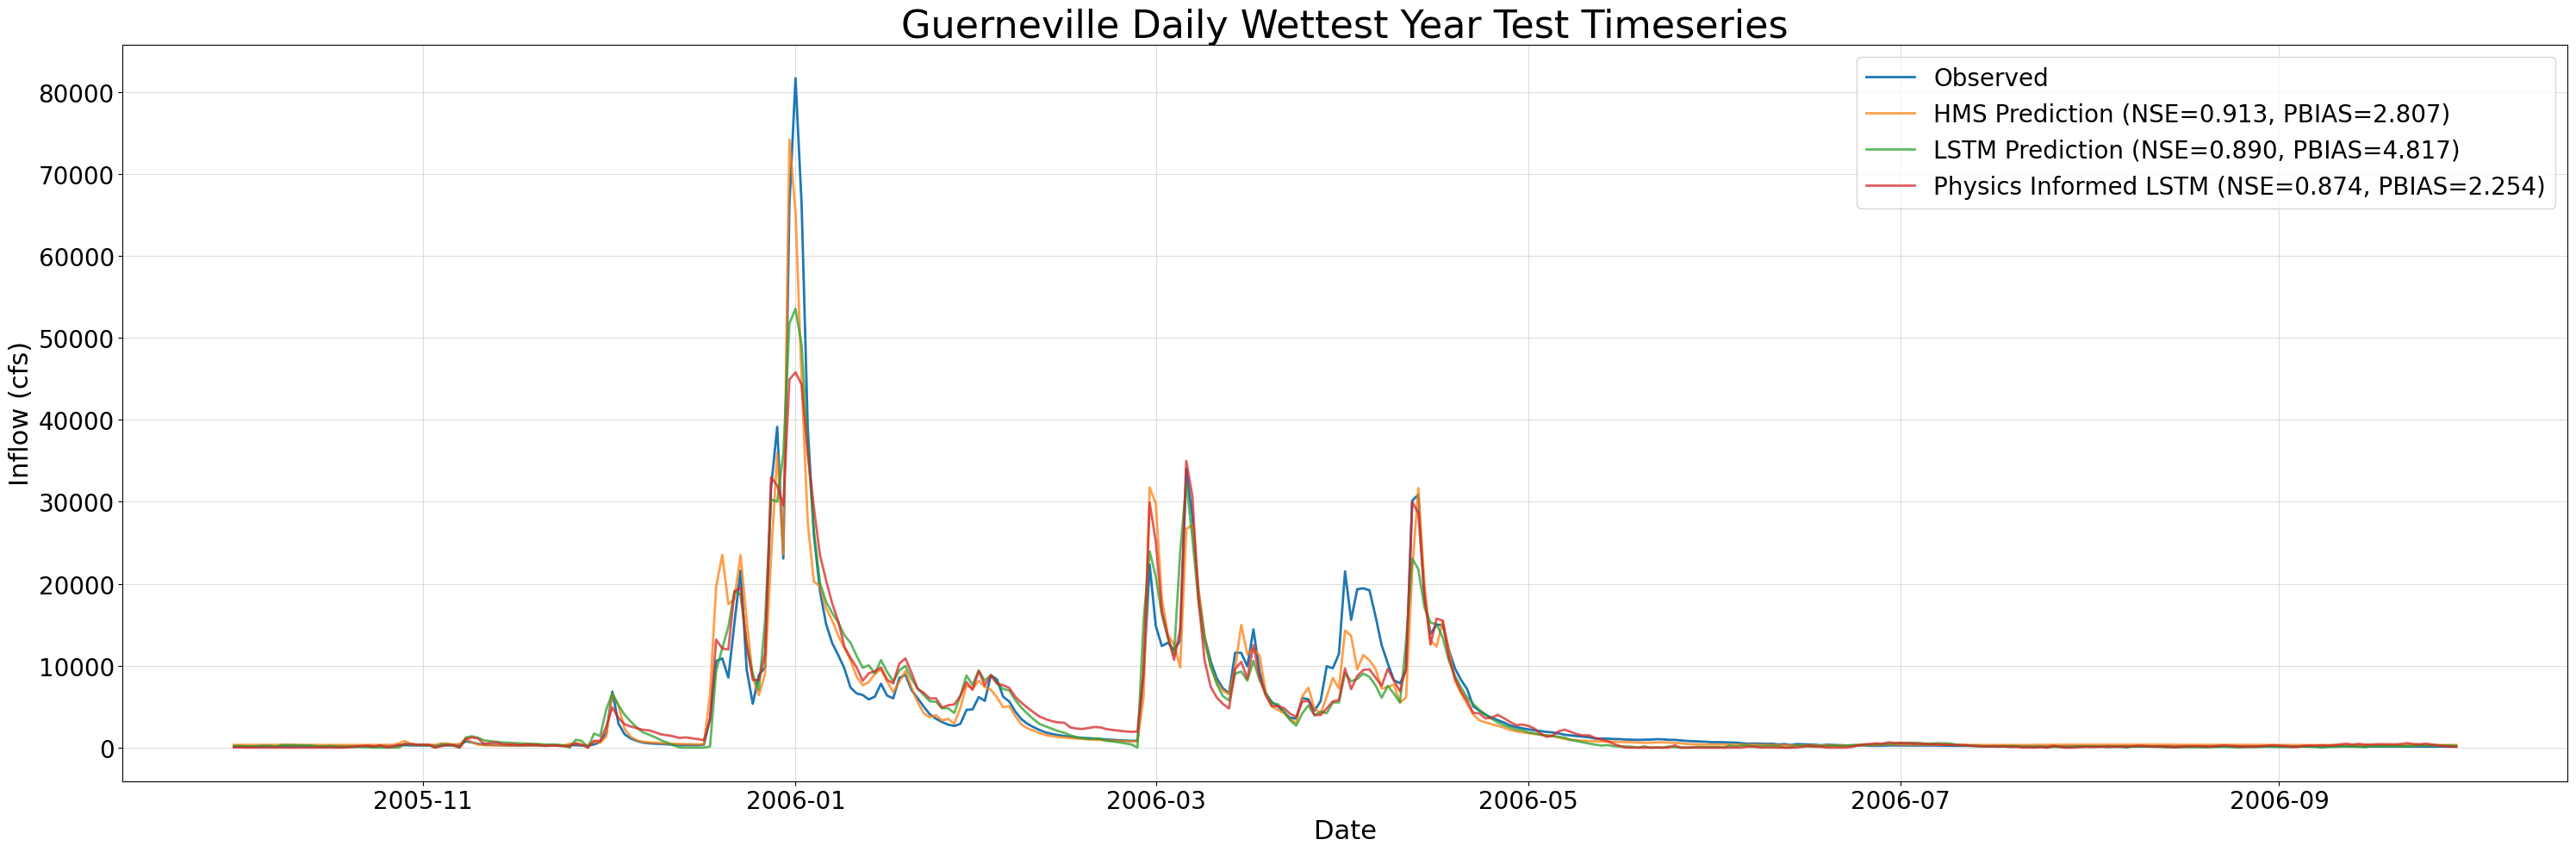

In [34]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Guerneville Daily Wettest Year Test Timeseries", backend="mpl", metrics=metric_list, start_date=wettest_start_test, end_date=wettest_end_test, metrics_out="guerneville_daily_test_wet_metrics.csv", ts_out="guerneville_daily_test_wet_combined_ts.csv", fig_out="guerneville_daily_test_wet_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Guerneville Daily Wettest Year Test Timeseries", backend="mpl", metrics=metric_list, start_date=wettest_start_test, end_date=wettest_end_test, metrics_out="guerneville_daily_test_wet_metrics.csv", ts_out="guerneville_daily_test_wet_combined_ts.csv", fig_out="guerneville_daily_test_wet_model_comparison.png", legend_font=20, axis_font=22)

In [35]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Guerneville Daily Wettest Year Test Timeseries – Interactive", backend="plotly", metrics=metric_list, start_date=wettest_start_test, end_date=wettest_end_test, metrics_out="guerneville_daily_test_wet_metrics.csv", ts_out="guerneville_daily_test_wet_combined_ts.csv", legend_font=12, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Guerneville Daily Wettest Year Test Timeseries – Interactive", backend="plotly", metrics=metric_list, start_date=wettest_start_test, end_date=wettest_end_test, metrics_out="guerneville_daily_test_wet_metrics.csv", ts_out="guerneville_daily_test_wet_combined_ts.csv", legend_font=12, axis_font=22)

HMS
  NSE = 0.913
  PBIAS = 2.807
LSTM
  NSE = 0.890
  PBIAS = 4.817
PILSTM
  NSE = 0.874
  PBIAS = 2.254


##### Dryest Year Performance

HMS
  NSE = 0.729
  PBIAS = -8.618
LSTM
  NSE = 0.826
  PBIAS = 7.805
PILSTM
  NSE = 0.833
  PBIAS = -8.685


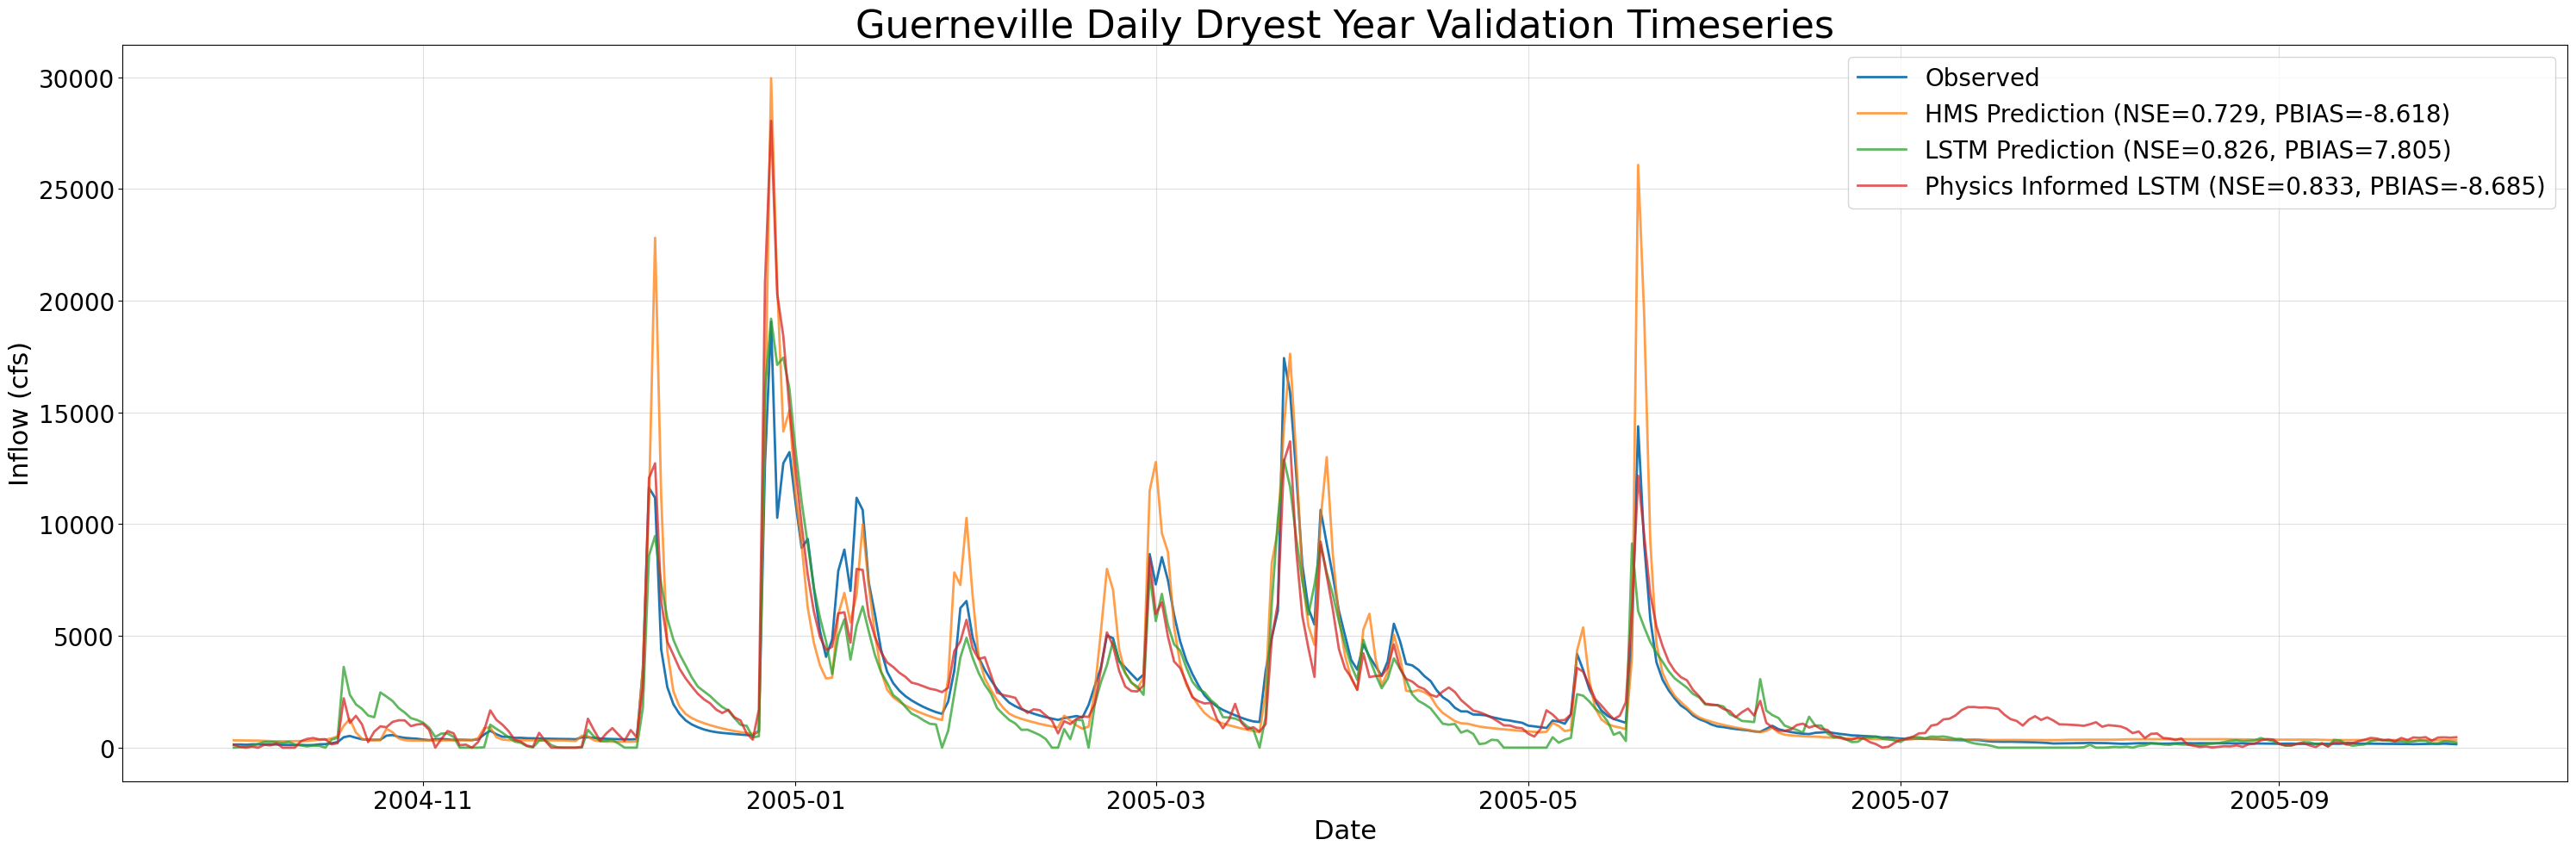

In [36]:
if not skip_best_model_validation:
    plot_timeseries_comparison(source=(no_physics_val_csv, physics_val_csv, path_to_physics_data), title="Guerneville Daily Dryest Year Timeseries", backend="mpl", metrics=metric_list, start_date=dryest_start_val, end_date=dryest_end_val, metrics_out="guerneville_daily_val_dry_metrics.csv", ts_out="guerneville_daily_val_dry_combined_ts.csv", fig_out="guerneville_daily_val_dry_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df_val, title="Guerneville Daily Dryest Year Validation Timeseries", backend="mpl", metrics=metric_list, start_date=dryest_start_val, end_date=dryest_end_val, metrics_out="guerneville_daily_val_dry_metrics.csv", ts_out="guerneville_daily_val_dry_combined_ts.csv", fig_out="guerneville_daily_val_dry_model_comparison.png", legend_font=20, axis_font=22)

HMS
  NSE = 0.523
  PBIAS = -64.185
LSTM
  NSE = 0.564
  PBIAS = -59.289
PILSTM
  NSE = 0.844
  PBIAS = -37.990


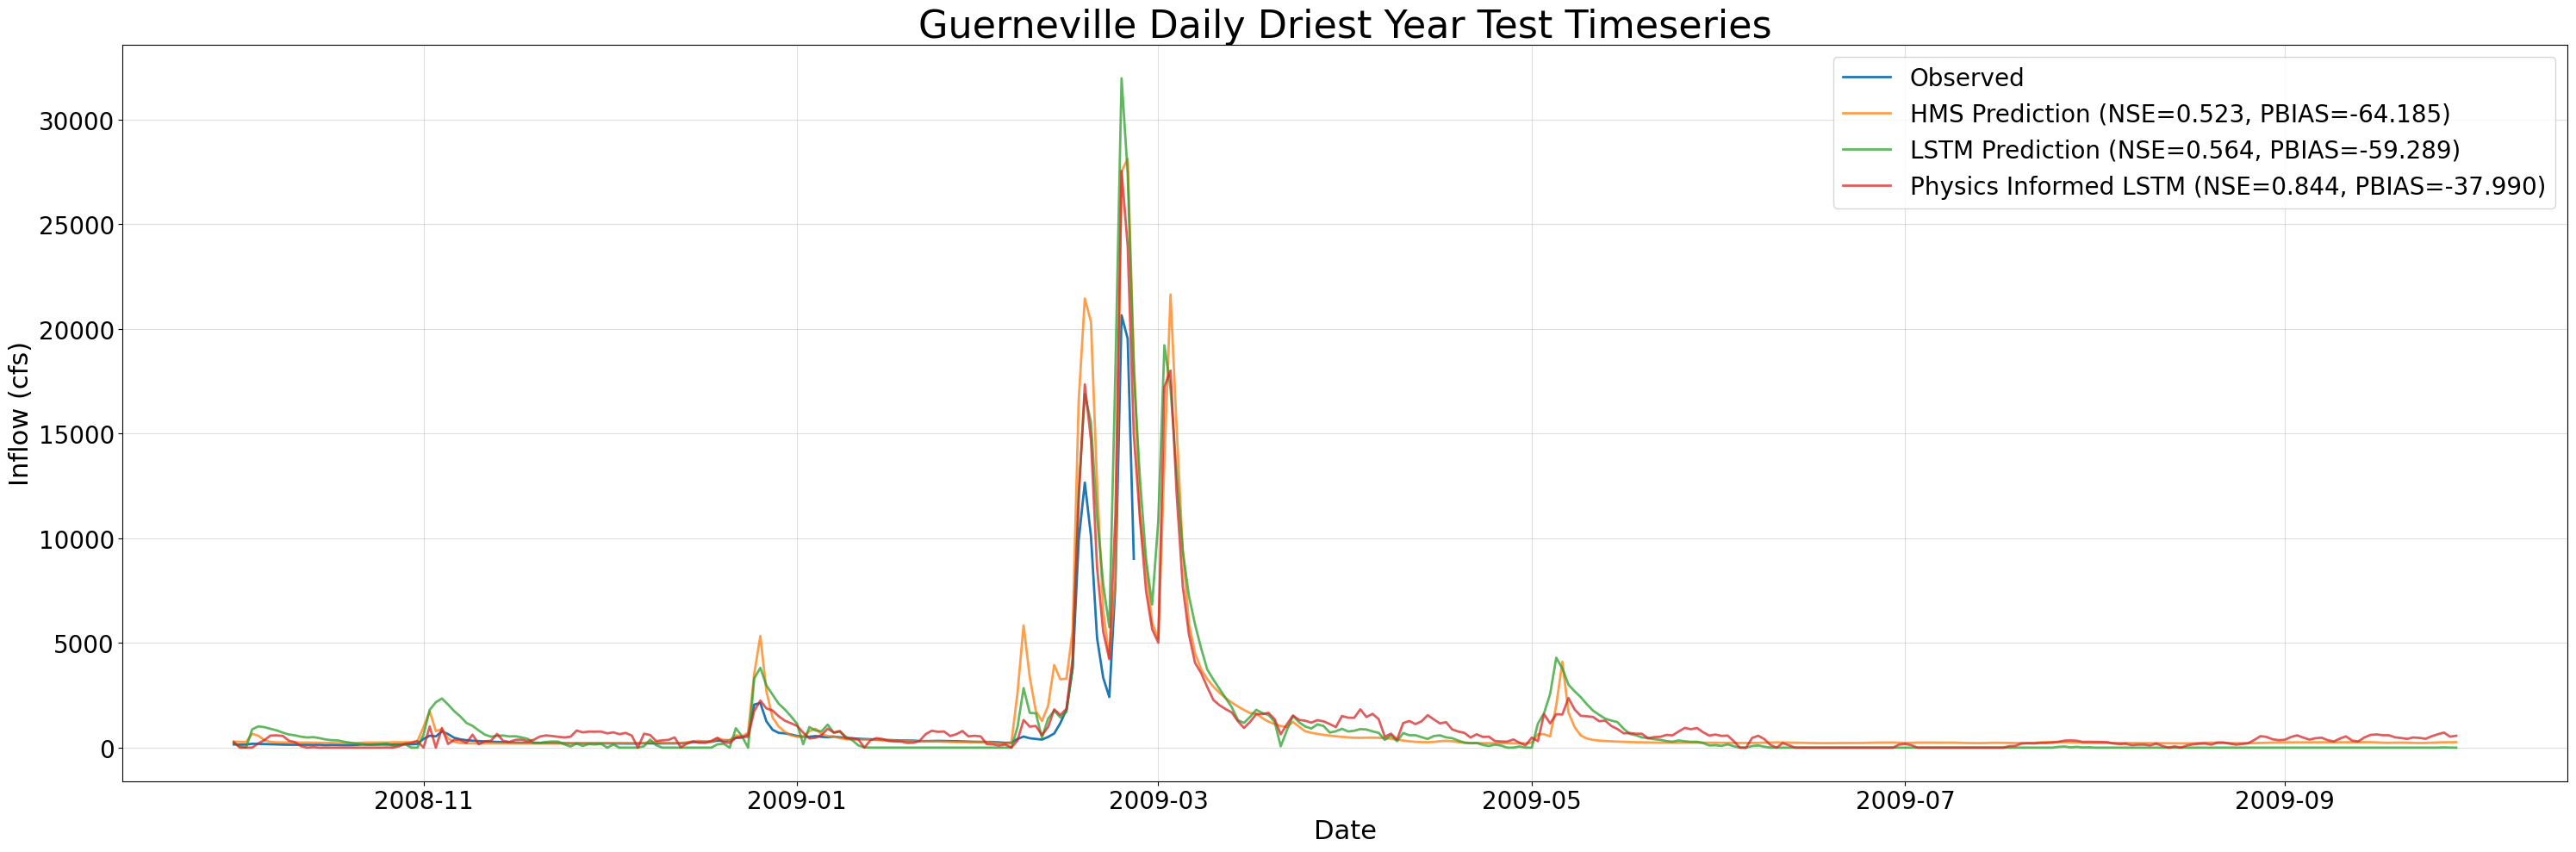

In [37]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Guerneville Daily Driest Year Test Timeseries", backend="mpl", metrics=metric_list, start_date=dryest_start_test, end_date=dryest_end_test, metrics_out="guerneville_daily_test_dry_metrics.csv", ts_out="guerneville_daily_test_dry_combined_ts.csv", fig_out="guerneville_daily_test_dry_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Guerneville Daily Driest Year Test Timeseries", backend="mpl", metrics=metric_list, start_date=dryest_start_test, end_date=dryest_end_test, metrics_out="guerneville_daily_test_dry_metrics.csv", ts_out="guerneville_daily_test_dry_combined_ts.csv", fig_out="guerneville_daily_test_dry_model_comparison.png", legend_font=20, axis_font=22)

In [38]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Guerneville Daily Driest Year Test Timeseries – Interactive", backend="plotly", metrics=metric_list, start_date=dryest_start_test, end_date=dryest_end_test, metrics_out="guerneville_daily_test_dry_metrics.csv", ts_out="guerneville_daily_test_dry_combined_ts.csv", legend_font=12, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Guerneville Daily Driest Year Test Timeseries – Interactive", backend="plotly", metrics=metric_list, start_date=dryest_start_test, end_date=dryest_end_test, metrics_out="guerneville_daily_test_dry_metrics.csv", ts_out="guerneville_daily_test_dry_combined_ts.csv", legend_font=12, axis_font=22)

HMS
  NSE = 0.523
  PBIAS = -64.185
LSTM
  NSE = 0.564
  PBIAS = -59.289
PILSTM
  NSE = 0.844
  PBIAS = -37.990


##### Gridded Timeseries Plots - Validation & Test

In [39]:
if not skip_best_model_validation:
    ts_triptych_v3((no_physics_val_csv, physics_val_csv, path_to_physics_data),wet_start=wettest_start_val, wet_end=wettest_end_val, dry_start=dryest_start_val, dry_end=dryest_end_val, save_path="guerneville_daily_TS_validation.png", legend_font=12, legend_boxpad=0.5, axis_font=12, date_fmt="%d-%b-%Y", figsize=(10, 10), dpi=600, hspace=0.2, main_title="Guerneville Daily Validation Period Timeseries Across Models", main_title_font=14, main_title_y=0.99, main_title_pad=0.05, row_titles=("Full Validation period","Most-wet water-year","Most-dry water-year"))

else:
    ts_triptych_v3(combined_df_val, wet_start=wettest_start_val, wet_end=wettest_end_val, dry_start=dryest_start_val, dry_end=dryest_end_val, save_path="guerneville_daily_TS_validation.png", legend_font=12, legend_boxpad=0.5, axis_font=12, date_fmt="%d‑%b‑%Y", figsize=(10, 10), dpi=600, hspace=0.2,main_title = "Guerneville Daily Validation Timeseries Across Models", main_title_font=14, main_title_y = 0.99, main_title_pad = 0.05, row_titles=("Full validation period", "Most‑wet water‑year", "Most‑dry water‑year"))

In [40]:
if not skip_best_model_test:
    ts_triptych_v3((no_physics_test_csv, physics_test_csv, path_to_physics_data), wet_start=wettest_start_test, wet_end=wettest_end_test,dry_start=dryest_start_test, dry_end=dryest_end_test, save_path="guerneville_daily_TS_testing.png", legend_font=12, legend_boxpad=0.5, axis_font=12, date_fmt="%d-%b-%Y", figsize=(10, 10), dpi=600, hspace=0.2, main_title="Guerneville Daily Test Period Timeseries Across Models", main_title_font=14, main_title_y=0.99, main_title_pad=0.05, row_titles=("Full Testing period","Most-wet water-year","Most-dry water-year"))

else:
    ts_triptych_v3(combined_df, wet_start=wettest_start_test, wet_end=wettest_end_test, dry_start=dryest_start_test, dry_end=dryest_end_test, save_path="guerneville_daily_TS_testing.png", legend_font=12, legend_boxpad=0.5, axis_font=12, date_fmt="%d‑%b‑%Y", figsize=(10, 10), dpi=600, hspace=0.2, main_title = "Guerneville Daily Test Period Timeseries Across Models", main_title_font=14, main_title_y = 0.99, main_title_pad = 0.05, row_titles=("Full Testing period", "Most‑wet water‑year", "Most‑dry water‑year"))

##### Gridded Scatterplots - Test

In [41]:
if not skip_best_model_test:
    scatter_triptych_pngs_v3((no_physics_test_csv, physics_test_csv, path_to_physics_data), wet_start=wettest_start_test, wet_end=wettest_end_test, dry_start=dryest_start_test, dry_end=dryest_end_test, out_dir="guerneville_daily_scatter", layout="horizontal", square_side=4.5, legend_font=16, axis_font=16, point_size=28, top_pad=.90, suptitle_y=1.04, dpi=600, row_titles=("Guerneville Daily – Full test period", "Guerneville Daily – Wettest water-year", "Guerneville Daily – Driest water-year"), resolution="daily")
else:
    scatter_pngs = scatter_triptych_pngs_v3(combined_df, wet_start = wettest_start_test, wet_end = wettest_end_test, dry_start = dryest_start_test,  dry_end = dryest_end_test, out_dir = "guerneville_daily_scatter", layout = "horizontal", square_side  = 4.5, legend_font  = 16, axis_font = 16, point_size = 28, top_pad = .90, suptitle_y = 1.04, dpi = 600, row_titles = ("Guerneville Daily – Full test period", "Guerneville Daily – Wettest water‑year", "Guerneville Daily – Driest water‑year"), resolution = "daily")